In [29]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import PIL
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
import tensorflow as tf
import keras
from keras import backend as K
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from sklearn.cross_validation import train_test_split
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Input
from keras.models import Model
import sys
from keras.callbacks import Callback
from keras.models import model_from_json
from keras.callbacks import LearningRateScheduler
import math
from keras.applications.xception import preprocess_input
from keras.callbacks import CSVLogger

In [31]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
session = tf.Session(config=config)

In [32]:
df = pd.read_csv('dataset/df_clusters.csv')
df = df.drop(['Unnamed: 0','Brand', 'Model', 'C', 'P1', 'P2', "P3", 'P4', 'P5', 'P6', "P7"], axis=1)
df = df[df['cluster']==1]

In [33]:
matrix = []
for i in tqdm(range(df.shape[0])):
    subdirs = [x[0] for x in os.walk('scrap/')]
    if 'scrap/'+df.iloc[i,0] in subdirs:
        for n_subdir, n_dirs, n_files in os.walk('scrap/'+df.iloc[i,0]):
            if n_subdir[-6:]!='points':
                for file in n_files:
                    temp = df.iloc[i,:].values
                    temp[-2] = 'scrap/'+df.iloc[i,0]+'/'+file
                    matrix.append(temp)

100%|██████████| 311/311 [00:04<00:00, 62.98it/s]


In [34]:
matrix = np.array(matrix)
matrix.shape
init_m = df.as_matrix()
fin_matrix = np.concatenate((init_m,matrix), axis=0)

In [35]:
fin_matrix = fin_matrix[:,1:-1]
labels = fin_matrix[:,:18]
path = fin_matrix[:,18]

In [36]:
fin_matrix.shape

(4825, 19)

In [37]:
basewidth = 299
baseheight = 299
ds = np.zeros((len(path),basewidth,baseheight,3),dtype='uint8')
labels_t_rem = []
for i in tqdm(range(len(path))):
    img = Image.open(path[i])
    if img.size[0] < img.size[1]:
        labels_t_rem.append(i)
        continue
    templ = np.full((basewidth,baseheight,3), 255, dtype='uint8')
    wpercent = (float(img.size[0]) / basewidth)
    height = int((float(img.size[1]) / float(wpercent)))
    img = img.resize((basewidth, height), PIL.Image.ANTIALIAS)
    np_img = np.array(img)
    #if np_img.shape[2] == 4:
    #    np_img = np_img[:,:,3]
    x_t_l = int(np.ceil(basewidth - np_img.shape[0])/2)
    x_b_l = x_t_l + np_img.shape[0]
    templ[x_t_l:x_b_l, :] = np_img[:,:,:3]
    ds[i] = templ

100%|██████████| 4825/4825 [01:13<00:00, 65.43it/s]


In [38]:
labels = np.delete(labels, labels_t_rem, axis=0)
ds = np.delete(ds, labels_t_rem, axis=0)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(ds, labels[:,0], test_size=0.2, random_state=42)

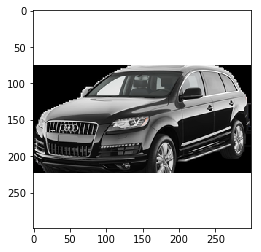

In [40]:
plt.imshow(ds[625]);
ds = ds.astype('float')

In [13]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip = True,
    preprocessing_function=preprocess_input
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)
datagen.fit(X_train)
datagen_test.fit(X_test)
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.75
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
csv_logger = CSVLogger('X0_cluster_1.csv', append=True, separator=';')
callbacks_list = [csv_logger, lrate]

In [14]:
base_model = keras.applications.Xception(weights='imagenet', include_top=False, input_shape = (299,299,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(1, activation='sigmoid')(x)
head_model = Model(inputs=base_model.input, outputs=predictions)
keras_optimizer = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True, decay=1e-5)
#keras_optimizer = optimizers.adam(lr=0.001)
head_model.compile(optimizer=keras_optimizer, loss='mean_absolute_error', metrics=['mae'])

In [15]:
head_model.fit_generator(datagen.flow(X_train, y_train, batch_size=16),steps_per_epoch=len(X_train)/32, \
                             epochs=20,validation_data=datagen_test.flow(X_test, y_test),validation_steps=len(X_test)/32,\
                        callbacks = callbacks_list)

Epoch 1/20
111/110 [==============================] - 78s 699ms/step - loss: 0.1848 - mean_absolute_error: 0.1848 - val_loss: 0.1822 - val_mean_absolute_error: 0.1822
Epoch 2/20
111/110 [==============================] - 73s 654ms/step - loss: 0.1890 - mean_absolute_error: 0.1890 - val_loss: 0.1818 - val_mean_absolute_error: 0.1818
Epoch 3/20
111/110 [==============================] - 72s 653ms/step - loss: 0.1859 - mean_absolute_error: 0.1859 - val_loss: 0.1803 - val_mean_absolute_error: 0.1803
Epoch 4/20
111/110 [==============================] - 73s 654ms/step - loss: 0.1797 - mean_absolute_error: 0.1797 - val_loss: 0.1801 - val_mean_absolute_error: 0.1801
Epoch 5/20
111/110 [==============================] - 73s 661ms/step - loss: 0.1844 - mean_absolute_error: 0.1844 - val_loss: 0.1808 - val_mean_absolute_error: 0.1808
Epoch 6/20
111/110 [==============================] - 74s 664ms/step - loss: 0.1786 - mean_absolute_error: 0.1786 - val_loss: 0.1803 - val_mean_absolute_error: 0.180

In [20]:
model_json = head_model.to_json()
with open("X0_cluster1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
head_model.save("X0_cluster1.hdf5")

/root/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


<Figure size 1296x432 with 0 Axes>

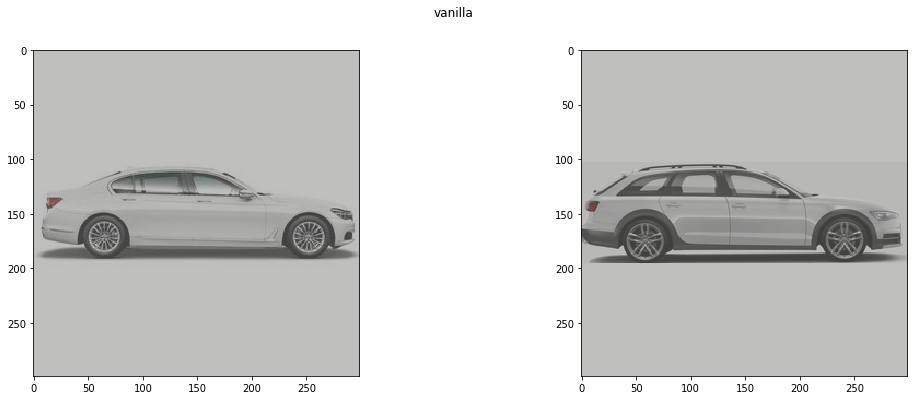

<Figure size 1296x432 with 0 Axes>

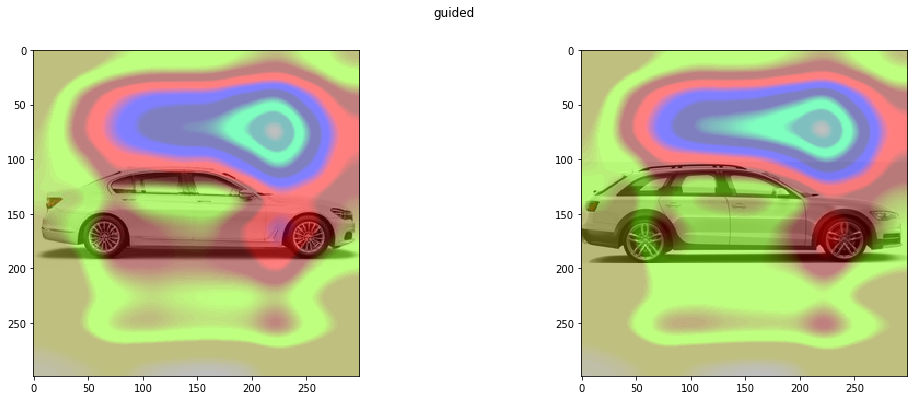

<Figure size 1296x432 with 0 Axes>

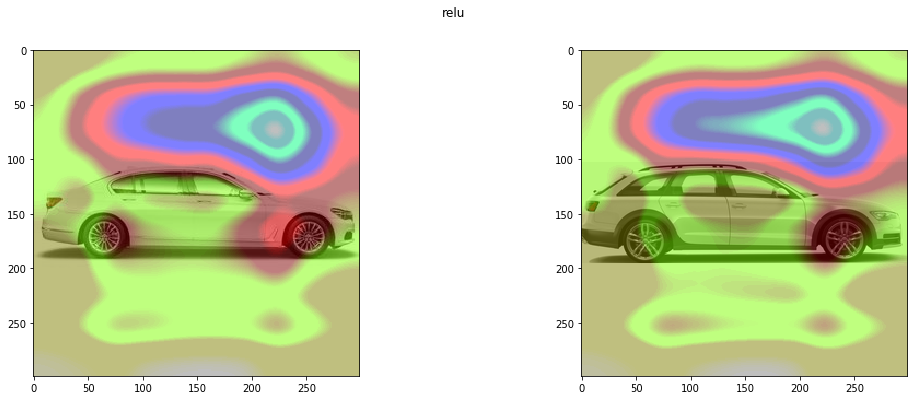

In [28]:
import matplotlib.cm as cm
from vis.utils import utils
from vis.visualization import visualize_cam
from vis.visualization import visualize_saliency, overlay
plt.rcParams['figure.figsize'] = (18, 6)
#img1 = utils.load_img('dataset/photos_nn/BMW/7_740Ld-xDrive_P0300(FNAFZ).jpg', target_size=(299, 299))
#img2 = utils.load_img('dataset/photos_nn/Audi/Audi-A6 allroad quattro-W1W1-K_MSIBN5D_EJ.png', target_size=(299, 299))
img1 = X_test[0]
layer_idx = utils.find_layer_idx(head_model, 'dense_2')
for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_cam(head_model, layer_idx, filter_indices=0, 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        jet_heatmap = jet_heatmap[:,:,:3,2]
        img_t_save = Image.fromarray(overlay(jet_heatmap, img))
        img_t_save.save(str(i)+"1.png")
        ax[i].imshow(overlay(jet_heatmap, img));